In [13]:
import tensorflow as tf

In [14]:
from tensorflow import lite
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [15]:
df = pd.read_csv('dataset/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR

<Axes: xlabel='type'>

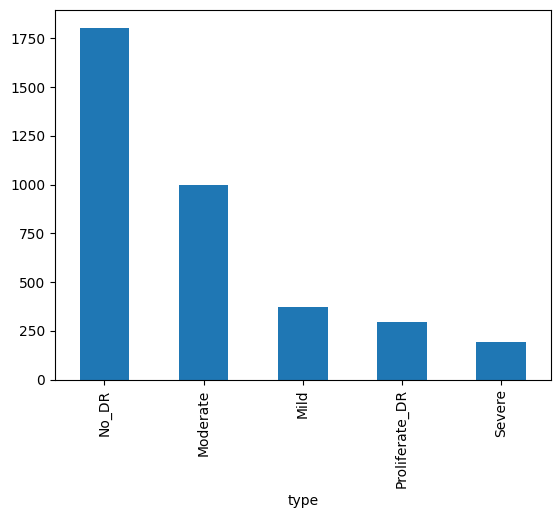

In [16]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='binary_type'>

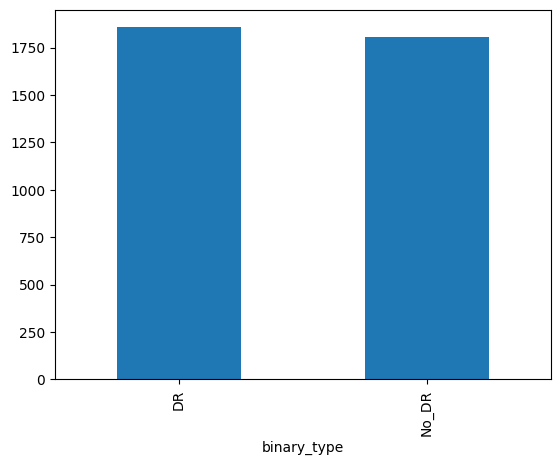

In [17]:
df['binary_type'].value_counts().plot(kind='bar')

In [18]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '/n')
print(test['type'].value_counts(), '/n')
print(val['type'].value_counts(), '/n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 /n
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 /n
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 /n


In [19]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [20]:
# Copy images to respective working directory
src_dir = 'dataset/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [21]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [22]:
from PIL import Image
from keras.preprocessing.image import load_img

In [23]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])



In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])


In [25]:
history = model.fit(train_batches,epochs=30,validation_data=val_batches)

Epoch 1/30


81/81 [==============================] - 35s 410ms/step - loss: 0.4584 - acc: 0.8076 - val_loss: 0.6350 - val_acc: 0.8127
Epoch 2/30
81/81 [==============================] - 14s 175ms/step - loss: 0.2724 - acc: 0.8958 - val_loss: 0.5754 - val_acc: 0.8436
Epoch 3/30
81/81 [==============================] - 15s 181ms/step - loss: 0.2319 - acc: 0.9215 - val_loss: 0.4893 - val_acc: 0.9055
Epoch 4/30
81/81 [==============================] - 15s 179ms/step - loss: 0.2176 - acc: 0.9305 - val_loss: 0.3706 - val_acc: 0.9255
Epoch 5/30
81/81 [==============================] - 15s 179ms/step - loss: 0.2026 - acc: 0.9372 - val_loss: 0.2827 - val_acc: 0.9327
Epoch 6/30
81/81 [==============================] - 15s 180ms/step - loss: 0.1866 - acc: 0.9411 - val_loss: 0.2225 - val_acc: 0.9291
Epoch 7/30
81/81 [==============================] - 15s 181ms/step - loss: 0.1800 - acc: 0.9418 - val_loss: 0.1972 - val_acc: 0.9236
Epoch 8/30
81/81 [==============================] - 15s 182ms/step 

In [26]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [27]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc)
print("Loss: ", loss)

18/18 [==============================] - 5s 283ms/step - loss: 0.1696 - acc: 0.9473
Accuracy:  0.9472727179527283
Loss:  0.16960951685905457


In [29]:
import cv2

In [30]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No Diabetic Retinopathy is detected')
    else:
        print('Diabetic Retinopathy is detected')

1/1 [==============================] - 0s 125ms/step
Diabetic Retinopathy is detected


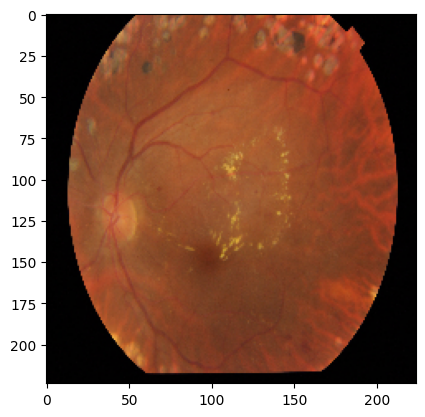

In [35]:
predict_class("dataset/colored_images/Proliferate_DR/3c78bfca247b.png")

1/1 [==============================] - 0s 109ms/step
No Diabetic Retinopathy is detected


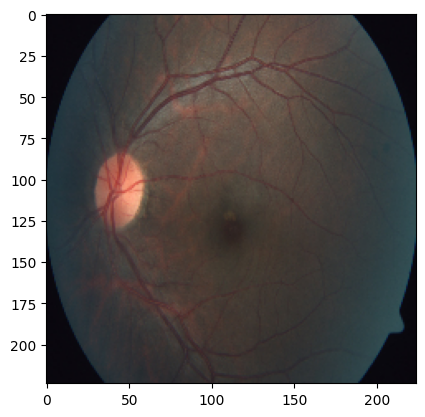

In [36]:
predict_class("dataset/colored_images/No_DR/0f364b7d4384.png")
